In [3]:
from gaussian_model import CenteredGM
import tqdm
import numpy as np
import torch as tch
import matplotlib.pyplot as plt
from scipy.optimize import brentq
%matplotlib inline
from experiment_manager.explorer import get_siblings
import json
from tqdm import tqdm


N = 50
sigma = np.zeros((N, N))
model_to_fit = CenteredGM(N, precision=sigma)


def j_map(c_emp, alpha, gamma, mu=1.):
    return (alpha*c_emp + gamma*mu - np.sqrt((alpha*c_emp - gamma*mu)**2 + 4 * alpha * gamma)) / (2. * gamma)


def rho_averaging(f, alpha, gaussian_model, n_samples=10e3):
    acc = []
    N = gaussian_model.dim
    for plop in range(int(n_samples // N)):
        spectrum, _ = tch.symeig(tch.from_numpy(model_to_fit.get_empirical_C(alpha * N)), eigenvectors=False)
        acc.extend(f(spectrum.cpu().numpy()))
    return np.mean(acc)

precision matrix :  [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 





covariance matrix :  [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [19]:
def solve_mu(gaussian_model, alpha, gamma, n_samples=1e4, _debug=True):
    avg = lambda func: rho_averaging(func, alpha, gaussian_model, n_samples=n_samples)
    
    # Because of the theoretical formula, we know that the mu normalization integral varies in 
    # 1 pm gamma / alpha -> impossible to solve numerically, too much uncertainty
    if gamma / alpha < 5e-2:
        return avg(lambda c: 1./c)
    
    mu_min = 0.98
    mu_max = rho_averaging(lambda C: 1./C, alpha, gaussian_model) 
    j_star = lambda C, mu: j_map(C, alpha, gamma, mu=mu)
    
    def surrogate(mu):
        plop = lambda C: 1. / (mu - j_star(C, mu))
        return 1. - avg(plop)
    
    # This to avoid issues when gamma too large, mu gets too close to 1
    if gamma / alpha > 1e2:
        try :
            roots = brentq(surrogate, mu_min, mu_max)
        except ValueError:
            return 1.
        
    # Regular pathways
    else :
        roots = brentq(surrogate, mu_min, mu_max)
    
    return roots

def plot_mu_gamma(gaussian_model, alpha, gamma_range, n_samples=1e4):
    mus = []
    for gamma in tqdm(gamma_range, leave=False):
        mus.append(solve_mu(gaussian_model, alpha, gamma))
    plt.figure()
    plt.semilogx(gamma_range, mus)
    plt.show()
    return mus

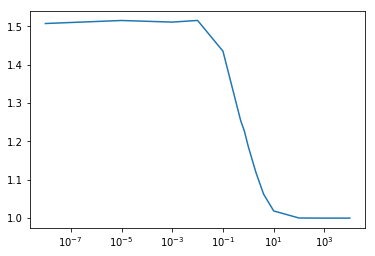

[1.507525949112323,
 1.5153943845045448,
 1.5112279299948383,
 1.5155222004981959,
 1.4353252996668964,
 1.2541594898654256,
 1.2266827057506275,
 1.1862714787205422,
 1.1188375904807968,
 1.062498252149626,
 1.018687779428927,
 1.000258006286152,
 1.0000025840596125,
 0.9999997045303272]

In [5]:
plot_mu_gamma(model_to_fit, 3., [1e-8, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 0.7, 1, 2., 4., 10, 100, 1000, 10000])

In [10]:
# def sample_eigenvalues(alpha, gaussian_model, n_samples=10e3):
#     acc = []
#     N = gaussian_model.dim
    
#     for plop in range(int(n_samples // N)):
#         spectrum, _ = tch.symeig(tch.from_numpy(model_to_fit.get_empirical_C(alpha * N)), eigenvectors=False)
#         acc.extend(spectrum.cpu().numpy())
#     return acc

def compute_L_test(alpha, gaussian_model, j_map_func, n_samples=10e3):
    acc = []
    N = gaussian_model.dim
    ref_spectrum = tch.symeig(tch.from_numpy(model_to_fit.covariance), eigenvectors=False)[0].cpu().numpy()

    for plop in range(int(n_samples // N)):
        spectrum, _ = tch.symeig(tch.from_numpy(model_to_fit.get_empirical_C(alpha * N)), eigenvectors=False)
        acc.extend(j_map_func(spectrum.cpu().numpy()) * ref_spectrum)
    return np.mean(acc)

def compute_likelihoods(gaussian_model, alpha, gamma, n_samples=10e3, _debug=False):
    # Seems like the issue is coming from Q2 -> if we hardcode it to the experimental value, 
    # everything works fine
    N = gaussian_model.dim
    mu = solve_mu(gaussian_model, alpha, gamma, _debug=_debug)
    
    j_star = lambda C: j_map(C, alpha, gamma, mu=mu)
    avg = lambda func: rho_averaging(func, alpha, gaussian_model, n_samples=n_samples)
    
    c_times_jc = lambda C: C * j_star(C)
    jc_square = lambda C: j_star(C) * j_star(C)
    log_mu_minus_j = lambda C: np.log(mu - j_star(C))
    
    # This seems to be true
    logZ = N / 2. * (mu - avg(log_mu_minus_j))
    
    # Not this
    q2 = avg(jc_square) * N / 2.

    # this would be true exccept for fucking Q2
    L_test = N / 2. * compute_L_test(alpha, gaussian_model, j_star) 
    L_train = N / 2. * avg(c_times_jc)
    L_gen = L_train - (gamma/alpha) * q2 
    
    if _debug:
        print('mu = {}'.format(mu))
        print('logZ = {}'.format(logZ))
        print('Ltrain {}, q2 {}, Lgen {}'.format(L_train, q2, L_gen))
    
    return L_train, L_test, L_gen, logZ, q2
    

In [30]:
def plot_likelihoods(n_samples=1e4, path='out_wishart/', base_exp='018c20ce90821514', n_l=0, n_r=0):
    siblings, values = get_siblings(base_exp, 'gamma', path=path)
    plop = len(values)
    siblings, values = siblings[n_l:plop-n_r], values[n_l:plop-n_r]

#     gamma_min, gamma_max = values[0], values[-1]
#     gamma_range = np.exp(np.linspace(np.log(gamma_min), np.log(gamma_max), 20.))
    
    with open(path+'raw/{}/params'.format(base_exp), 'r') as f:
        alpha = json.load(f)['alpha']
    
    gamma_values = values
    
    th_acc = np.zeros((5, len(gamma_values)))
    
    L_train_mean = np.zeros(len(gamma_values))
    L_train_std = np.zeros(len(gamma_values))
    
    L_test_mean = np.zeros(len(gamma_values))
    L_test_std = np.zeros(len(gamma_values))
    
    L_gen_mean = np.zeros(len(gamma_values))
    L_gen_std = np.zeros(len(gamma_values))
    
    logZ_mean = np.zeros(len(gamma_values))
    logZ_mean_th = np.zeros(len(gamma_values))
    
    Q2_mean = np.zeros(len(gamma_values))
    Q2_std = np.zeros(len(gamma_values))
    
    for idx, gamma in enumerate(tqdm(gamma_values)):
        L_train_mean[idx] = np.load(path+'raw/{}/L_train.npy'.format(siblings[idx]))[:, -100:].mean()
        L_train_std[idx] = np.load(path+'raw/{}/L_train.npy'.format(siblings[idx]))[:, -100:].std()
        
        L_test_mean[idx] = np.load(path+'raw/{}/L_test.npy'.format(siblings[idx]))[:, -100:].mean()
        L_test_std[idx] = np.load(path+'raw/{}/L_test.npy'.format(siblings[idx]))[:, -100:].std()
        
        L_gen_mean[idx] = np.load(path+'raw/{}/L_gen.npy'.format(siblings[idx]))[:, -100:].mean()
        L_gen_std[idx] = np.load(path+'raw/{}/L_gen.npy'.format(siblings[idx]))[:, -100:].std()
        
        logZ_mean[idx] = np.load(path+'raw/{}/logZ.npy'.format(siblings[idx]))[:, -100:].mean()
        
        Q2_mean[idx] = np.load(path+'raw/{}/Q2.npy'.format(siblings[idx]))[:, -100:].mean()
        Q2_std[idx] = np.load(path+'raw/{}/Q2.npy'.format(siblings[idx]))[:, -100:].std()
        
        th_acc[:, idx] = np.array(compute_likelihoods(model_to_fit, alpha, gamma, n_samples=n_samples))
        logZ_mean_th[idx] = th_acc[3, idx]
        
    plt.figure()
    plt.title(r'Likelihoods as a function of $\gamma$ for $alpha$={}'.format(alpha))
    plt.plot(gamma_values, th_acc[0, :] - th_acc[3, :], c='b', label=r'$L^{train} th$')
    plt.plot(gamma_values, th_acc[1, :] - th_acc[3, :], c='r', label=r'$L^{test} th$')
    plt.plot(gamma_values, th_acc[2, :] - th_acc[3, :], c='g', label=r'$L^{gen}th$')
    plt.errorbar(gamma_values, L_train_mean - logZ_mean_th, yerr=L_train_std, fmt='o', c='b', label=r'$L^{train} exp$')
    plt.errorbar(gamma_values, L_test_mean - logZ_mean_th, yerr=L_test_std, fmt='o', c='r', label=r'$L^{test} exp$')
    plt.errorbar(gamma_values, L_gen_mean - logZ_mean_th, yerr=L_gen_std, fmt='o', c='g', label=r'$L^{gen} exp$')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel('Log likelihoods')
    plt.xscale('log')
#     plt.yscale('log')
#     plt.ylim([-2. * np.abs(np.min(L_gen_mean[:-2])), 2. * np.max(L_train_mean[:-2])])
    plt.legend(loc='best')
    plt.show()
    
    plt.figure()
    plt.title(r'Q2 as a function of $\gamma$ for $alpha$={}'.format(alpha))
    plt.errorbar(gamma_values, Q2_mean, yerr=Q2_std, fmt='o', c='b', label=r'$Q2 exp$')
    plt.plot(gamma_values, th_acc[-1])
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    
    
    plt.figure()
    plt.plot(gamma_values, (th_acc[2, :]-th_acc[1, :]) / (th_acc[0, :]-th_acc[1, :]), c='b', label=r'$\frac{L^{gen}-L^{test}}{L^{train}-L^{test}}$')
#     plt.plot(gamma_values, (L_gen_mean - L_test_mean))
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel('Likelihood ratio')
    plt.xscale('log')
    plt.legend(loc='best')
    plt.show()
    


  0%|          | 0/9 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-05 1.e-04 1.e-03 1.e-02 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05], visit ['8be97ac014cd813f' 'c3e7cc27ea66ad61' '687e637b1de74f1c'
 'f335128a2c9a4fa3' 'a5ce90dca9f1e862' 'e6a26f614cb1d35c'
 'dcc00ef2ab1b71be' '3a44f94ea4bcb02c' '1b8a9e571e356342'
 'c5822275440fa0a1']



100%|██████████| 9/9 [00:42<00:00,  6.16s/it]


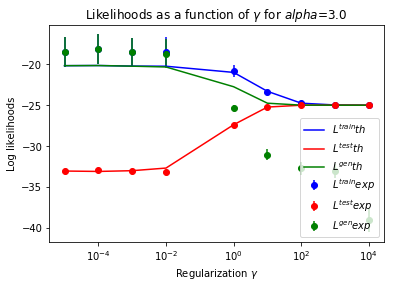

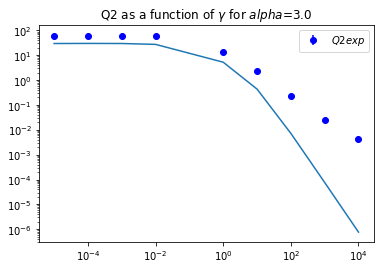

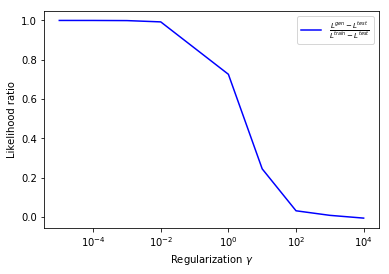

In [31]:
plot_likelihoods(base_exp='1b8a9e571e356342', n_r=1)



  0%|          | 0/9 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-05 1.e-04 1.e-03 1.e-02 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05], visit ['3a58a60b8e73a632' '7d7559b4c41f6d62' 'd72e2c16648088d8'
 '93e04b132f42a105' '5851cebe5681cd45' 'b9095f0a6f0349e5'
 'ad078e0ad6789a49' '018c20ce90821514' 'd4a58dfb9036b6b5'
 '09c308629e49f34e']




 11%|█         | 1/9 [00:02<00:18,  2.28s/it]

 22%|██▏       | 2/9 [00:04<00:15,  2.19s/it]

 33%|███▎      | 3/9 [00:06<00:13,  2.19s/it]

 44%|████▍     | 4/9 [00:08<00:10,  2.15s/it]

 56%|█████▌    | 5/9 [00:25<00:25,  6.46s/it]

 67%|██████▋   | 6/9 [00:41<00:28,  9.49s/it]

 78%|███████▊  | 7/9 [00:50<00:18,  9.28s/it]

 89%|████████▉ | 8/9 [01:02<00:10, 10.04s/it]

100%|██████████| 9/9 [01:15<00:00, 11.03s/it]



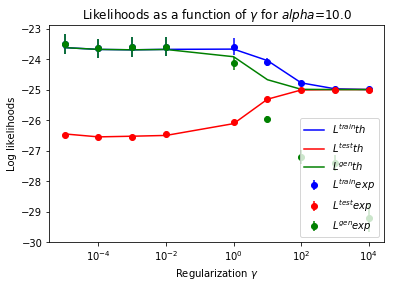

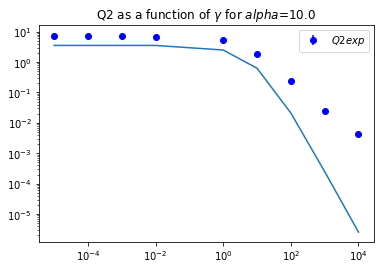

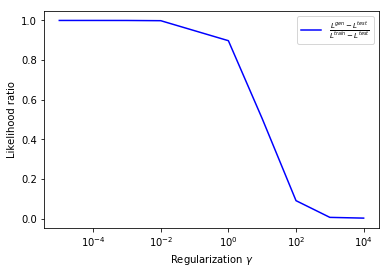

In [33]:
plot_likelihoods(n_r=1)



  0%|          | 0/9 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-05 1.e-04 1.e-03 1.e-02 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05], visit ['89a6b294690a4980' '318197482e9a740e' '6d175e8392fc0b2d'
 'bfeab2ff38f1959e' '54dea6d2ee629d8f' '6c1d8da6be42a921'
 '73ba0498a173987b' 'b32674a9cdec1583' '0a872e6e4f52f324'
 '9c1ee51222e0cf2f']




 11%|█         | 1/9 [00:15<02:05, 15.65s/it]

 22%|██▏       | 2/9 [00:31<01:49, 15.65s/it]

 33%|███▎      | 3/9 [00:46<01:33, 15.65s/it]

 44%|████▍     | 4/9 [01:01<01:17, 15.47s/it]

 56%|█████▌    | 5/9 [01:17<01:01, 15.34s/it]

 67%|██████▋   | 6/9 [03:10<02:13, 44.67s/it]

 78%|███████▊  | 7/9 [04:23<01:46, 53.30s/it]

 89%|████████▉ | 8/9 [05:49<01:03, 63.03s/it]

100%|██████████| 9/9 [07:29<00:00, 74.25s/it]



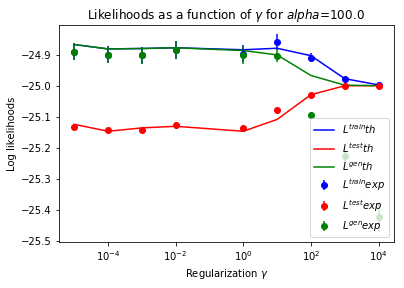

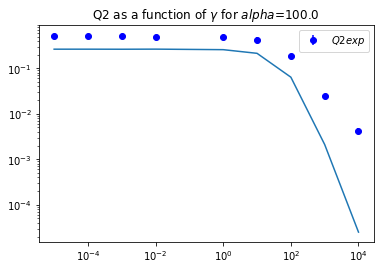

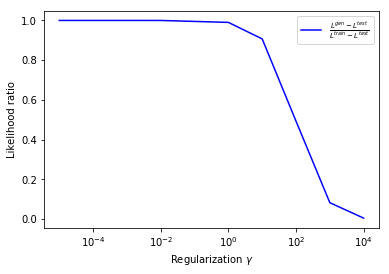

In [34]:
plot_likelihoods(base_exp='54dea6d2ee629d8f', n_r=1)

In [26]:
from experiment_manager.explorer import get_siblings
import json

sigma = np.zeros((N, N))
model_to_fit = CenteredGM(N, precision=sigma)

def experiment_comparison_logZ(path='out_wishart/', base_exp='1b8a9e571e356342'):
    siblings, values = get_siblings(base_exp, 'gamma', path=path)    
    with open(path+'raw/{}/params'.format(base_exp), 'r') as f:
        alpha = json.load(f)['alpha']
        
        
    siblings, values = siblings[2:], values[2:]
    print('Working with alpha = {}'.format(alpha))
    logZ_exp_mean = []
    logZ_exp_std = []
    logZ_the = []
    
    Q2_exp_mean = []
    Q2_exp_std = []
    Q2_the = []
    
    for folder, gamma in zip(siblings, values):
        print('Experiment with hash {} : gamma= {}'.format(folder, gamma))
#         logZ_exp_mean.append(np.load(path+'raw/{}/logZ_avg.npy'.format(folder))[-100:].mean())
#         logZ_exp_std.append(np.load(path+'raw/{}/logZ_std.npy'.format(folder))[-100:].mean())
        
        plop = compute_likelihoods(model_to_fit, alpha, gamma)[-2:]
    
        logZ_exp_mean.append(np.load(path+'raw/{}/logZ.npy'.format(folder))[:, -100:].mean())
        logZ_exp_std.append(np.load(path+'raw/{}/logZ.npy'.format(folder))[:, -100:].std())
        logZ_the.append(plop[0])
        print('LogZ Experiment : {} pm {}, theory : {}'.format(logZ_exp_mean[-1], logZ_exp_std[-1], logZ_the[-1]))
        
        Q2_exp_mean.append(np.load(path+'raw/{}/Q2.npy'.format(folder))[:, -100:].mean())
        Q2_exp_std.append(np.load(path+'raw/{}/Q2.npy'.format(folder))[:, -100:].std())
        Q2_the.append(plop[1])
        print('Q2 Experiment: {} pm {}, theory : {}'.format(Q2_exp_mean[-1], Q2_exp_std[-1], Q2_the[-1]))
        print('{} pm {}'.format(Q2_exp_mean[-1] / Q2_the[-1], Q2_exp_std[-1] / Q2_the[-1]))
        
    plt.figure()
    plt.errorbar(values, logZ_exp_mean, yerr=logZ_exp_std, label='Experiment')
    plt.errorbar(values, logZ_the, label='Theory')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel(r'LogZ')
    plt.legend()
    plt.title(r'$logZ(\gamma)$ for fixed $\alpha$={}'.format(alpha))
    plt.show()
    
    plt.figure()
    plt.errorbar(values, Q2_exp_mean, yerr=Q2_exp_std, label='Experiment')
    plt.errorbar(values, Q2_the, label='Theory')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel(r'Q2')
    plt.legend()
    plt.title(r'$Q2(\gamma)$ for fixed $\alpha$={}'.format(alpha))
    plt.show()


def experiment_comparison_mu(path='out_wishart/', base_exp='1b8a9e571e356342'):
    siblings, values = get_siblings(base_exp, 'gamma', path=path)    
    with open(path+'raw/{}/params'.format(base_exp), 'r') as f:
        alpha = json.load(f)['alpha']
    
    print('Working with alpha = {}'.format(alpha))
    
    mu_exp_mean = []
    mu_exp_std = []
    mu_the = []
    
    for folder, gamma in zip(siblings, values):
        print('Experiment with hash {} : gamma= {}'.format(folder, gamma))
        mu_exp_mean.append(np.load(path+'raw/{}/mus.npy'.format(folder))[:, -100:].mean())
        mu_exp_std.append(np.load(path+'raw/{}/mus.npy'.format(folder))[:, -100:].std())
        
#         mu_exp_mean.append(np.load(path+'raw/{}/mu_avg.npy'.format(folder))[-100:].mean())
#         mu_exp_std.append(np.load(path+'raw/{}/mu_std.npy'.format(folder))[-100:].mean())
        
        mu_the.append(solve_mu(model_to_fit, alpha, gamma))
        print('Experiment : {} pm {}, theory : {}'.format(mu_exp_mean[-1], mu_exp_std[-1], mu_the[-1]))
        
    plt.figure()
    plt.errorbar(values, mu_exp_mean, yerr=mu_exp_std, label='Experiment')
    plt.errorbar(values, mu_the, label='Theory')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel(r'Lagrange multiplier $\mu$')
    plt.legend()
    plt.title(r'$\mu(\gamma)$ for fixed $\alpha$={}'.format(alpha))
    plt.show()

precision matrix :  [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 





covariance matrix :  [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


To vary parameter gamma in [1.e-05 1.e-04 1.e-03 1.e-02 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05], visit ['8be97ac014cd813f' 'c3e7cc27ea66ad61' '687e637b1de74f1c'
 'f335128a2c9a4fa3' 'a5ce90dca9f1e862' 'e6a26f614cb1d35c'
 'dcc00ef2ab1b71be' '3a44f94ea4bcb02c' '1b8a9e571e356342'
 'c5822275440fa0a1']
Working with alpha = 3.0
Experiment with hash 687e637b1de74f1c : gamma= 0.001
LogZ Experiment : 39.29764754176624 pm 4.0191452488190285, theory : 33.04047647740596
Q2 Experiment: 59.17853921413422 pm 7.6725047836591544, theory : 30.209513923959275
1.9589371534773192 pm 0.25397643944128684
Experiment with hash f335128a2c9a4fa3 : gamma= 0.01
LogZ Experiment : 39.36497247839309 pm 4.081604811102091, theory : 33.128170246646945
Q2 Experiment: 59.19989113330841 pm 8.56486915485009, theory : 27.435180262089027
2.1578094464031303 pm 0.31218563439458613
Experiment with hash a5ce90dca9f1e862 : gamma= 1.0
LogZ Experiment : 30.313872985947846 pm 3.052198177640521, theory : 27.460622015778704
Q2 Experi

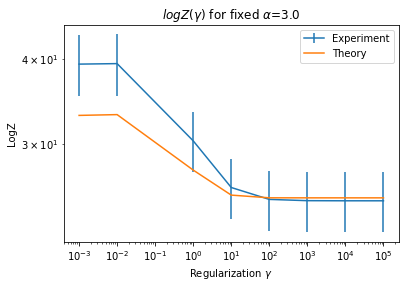

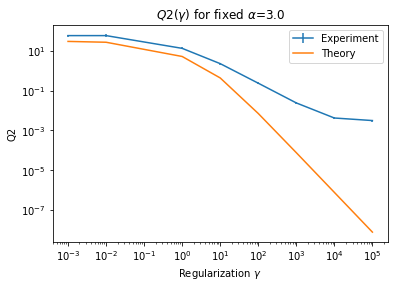

In [27]:
experiment_comparison_logZ()